# Electron REST API

This website provides an electron insert factor REST API. A demonstration of the use of this API is given below. The source code for this heroku app is available at https://github.com/SimonBiggs/electronfactor-server.

In [1]:
# Copyright (C) 2016 Simon Biggs
# This program is free software: you can redistribute it and/or
# modify it under the terms of the GNU Affero General Public
# License as published by the Free Software Foundation, either
# version 3 of the License, or (at your option) any later version.
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
# Affero General Public License for more details.
# You should have received a copy of the GNU Affero General Public
# License along with this program. If not, see
# http://www.gnu.org/licenses/.

import time
import json
import requests

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
% matplotlib inline

## Parameterising an insert shape

To parameterise the insert shape x and y coordinates of the shape need to be sent to the url http://electronapi.simonbiggs.net/parameterise as follows.

First create a payload with x and y coordinates.

In [2]:
insert_x = [0.99, -0.14, -1.0, -1.73, -2.56, -3.17, -3.49, -3.57, -3.17, -2.52, -1.76,
    -1.04, -0.17, 0.77, 1.63, 2.36, 2.79, 2.91, 3.04, 3.22, 3.34, 3.37, 3.08, 2.54,
    1.88, 1.02, 0.99]
insert_y = [5.05, 4.98, 4.42, 3.24, 1.68, 0.6, -0.64, -1.48, -2.38, -3.77, -4.81,
    -5.26, -5.51, -5.58, -5.23, -4.64, -3.77, -2.77, -1.68, -0.29, 1.23, 2.68, 3.8,
    4.6, 5.01, 5.08, 5.05]

payload = json.dumps({'x': insert_x, 'y': insert_y})
payload

'{"x": [0.99, -0.14, -1.0, -1.73, -2.56, -3.17, -3.49, -3.57, -3.17, -2.52, -1.76, -1.04, -0.17, 0.77, 1.63, 2.36, 2.79, 2.91, 3.04, 3.22, 3.34, 3.37, 3.08, 2.54, 1.88, 1.02, 0.99], "y": [5.05, 4.98, 4.42, 3.24, 1.68, 0.6, -0.64, -1.48, -2.38, -3.77, -4.81, -5.26, -5.51, -5.58, -5.23, -4.64, -3.77, -2.77, -1.68, -0.29, 1.23, 2.68, 3.8, 4.6, 5.01, 5.08, 5.05]}'

Then send the payload to the api and retrieve the results. Make sure to loop the request until complete is returned as true.

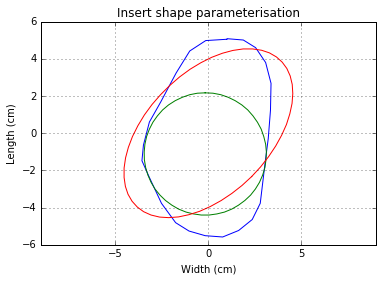

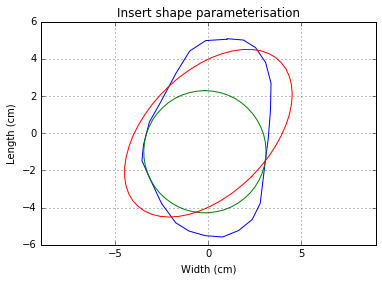

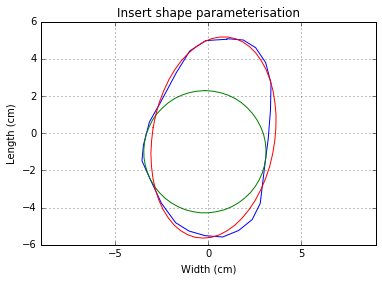

In [3]:
complete = False

while not(complete):
    response = requests.post(
        "http://electronapi.simonbiggs.net/parameterise", 
    #     "http://localhost:5000/parameterise",
        data=payload)

    result = json.loads(response.text)

    insert_width = result['width']
    insert_length = result['length']
    circle = result['circle']
    ellipse = result['ellipse']
    complete = result['complete']
    
    if circle is not(None):
        plt.figure()
        plt.plot(insert_x, insert_y)
        plt.axis('equal')

        plt.plot(circle['x'], circle['y'])
        plt.title('Insert shape parameterisation')
        plt.xlabel('Width (cm)')
        plt.ylabel('Length (cm)')
        plt.grid(True)
        
        if ellipse is not(None):
            plt.plot(ellipse['x'], ellipse['y'])
            
        plt.show()

    time.sleep(2)

The final response from the server can be plotted as so.

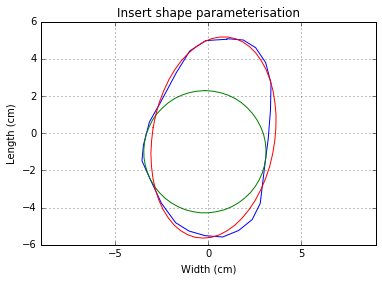

In [4]:
plt.plot(insert_x, insert_y)
plt.axis('equal')

plt.plot(circle['x'], circle['y'])
plt.plot(ellipse['x'], ellipse['y'])

plt.title('Insert shape parameterisation')
plt.xlabel('Width (cm)')
plt.ylabel('Length (cm)')

plt.grid(True)

## Creating the electron insert spline model

Once a range of widths, lengths, and factors have been collected (at least 8) for a single applicator, ssd and energy they can be by sending them to http://electronapi.simonbiggs.net/model as follows.

First create a payload to be sent to the server.

In [5]:
width_data = [
    3.15, 3.16, 3.17, 3.17, 3.17, 3.55, 3.66, 3.71, 4.2, 4.21, 
    4.21, 4.21, 4.21, 4.38, 4.48, 4.59, 4.59, 4.67, 5.21, 5.25,
    5.26, 5.26, 5.26, 5.34, 5.43, 5.72, 5.86, 6, 6.04, 6.08, 6.3,
    6.31, 6.41, 6.53, 6.54, 6.64, 6.78, 6.9, 7.08, 7.18, 7.21, 7.36, 
    7.56, 7.6, 7.64, 7.82, 8.06, 8.4, 9.45]

length_data = [
    3.16, 5.25, 13.64, 6.83, 9.43, 7.7, 5.04, 4.36, 4.21, 10.51, 
    13.65, 6.82, 8.41, 5.47, 7.29, 5.67, 6.54, 6.28, 11.4, 5.26, 
    10.52, 13.66, 8.41, 9.64, 11.02, 11.6, 8.62, 7.98, 9.22, 6.64, 
    6.33, 8.24, 8.69, 10.99, 8.41, 9.81, 10.98, 10.25, 10.77, 11.27, 
    9.03, 7.37, 10.05, 10.26, 8.99, 10.85, 11.85, 8.42, 9.47
]

factor_data = [
    0.9294, 0.9346, 0.9533, 0.9488, 0.9488, 0.9443, 0.9434, 0.9488, 
    0.956, 0.9709, 0.9756, 0.9606, 0.9709, 0.9634, 0.9606, 0.9588, 0.9681, 
    0.9737, 0.9881, 0.9709, 0.9881, 0.9872, 0.9833, 0.993, 0.9872, 0.999, 
    0.9891, 0.9911, 0.999, 0.993, 0.9862, 0.9921, 0.999, 1, 0.993, 0.999, 
    1.007, 0.999, 1.005, 0.999, 1.0101, 1.003, 1.004, 1.0142, 1.003, 1.002, 
    1.007, 1.007, 1.0081
]

payload = json.dumps(
    {'width': width_data, 'length':length_data, 'factor':factor_data})
payload


'{"length": [3.16, 5.25, 13.64, 6.83, 9.43, 7.7, 5.04, 4.36, 4.21, 10.51, 13.65, 6.82, 8.41, 5.47, 7.29, 5.67, 6.54, 6.28, 11.4, 5.26, 10.52, 13.66, 8.41, 9.64, 11.02, 11.6, 8.62, 7.98, 9.22, 6.64, 6.33, 8.24, 8.69, 10.99, 8.41, 9.81, 10.98, 10.25, 10.77, 11.27, 9.03, 7.37, 10.05, 10.26, 8.99, 10.85, 11.85, 8.42, 9.47], "width": [3.15, 3.16, 3.17, 3.17, 3.17, 3.55, 3.66, 3.71, 4.2, 4.21, 4.21, 4.21, 4.21, 4.38, 4.48, 4.59, 4.59, 4.67, 5.21, 5.25, 5.26, 5.26, 5.26, 5.34, 5.43, 5.72, 5.86, 6, 6.04, 6.08, 6.3, 6.31, 6.41, 6.53, 6.54, 6.64, 6.78, 6.9, 7.08, 7.18, 7.21, 7.36, 7.56, 7.6, 7.64, 7.82, 8.06, 8.4, 9.45], "factor": [0.9294, 0.9346, 0.9533, 0.9488, 0.9488, 0.9443, 0.9434, 0.9488, 0.956, 0.9709, 0.9756, 0.9606, 0.9709, 0.9634, 0.9606, 0.9588, 0.9681, 0.9737, 0.9881, 0.9709, 0.9881, 0.9872, 0.9833, 0.993, 0.9872, 0.999, 0.9891, 0.9911, 0.999, 0.993, 0.9862, 0.9921, 0.999, 1, 0.993, 0.999, 1.007, 0.999, 1.005, 0.999, 1.0101, 1.003, 1.004, 1.0142, 1.003, 1.002, 1.007, 1.007, 1.0081]}'

Send the payload to the server api and retrieve the results.

In [6]:
response = requests.post(
    "http://electronapi.simonbiggs.net/model", 
#     "http://localhost:5000/model",
    data=payload)
result = json.loads(response.text)
model_width = np.array(result['model_width'], dtype=np.float)
model_length = np.array(result['model_length'], dtype=np.float)
model_factor = np.array(result['model_factor'], dtype=np.float)

The result from the server can be plotted in the following way if you wish.

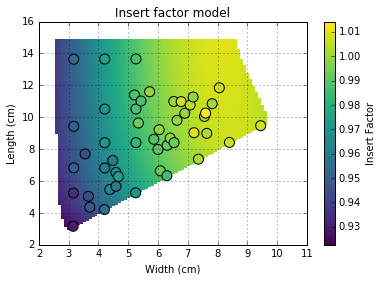

In [7]:
vmin = np.nanmin(np.concatenate([np.ravel(model_factor), factor_data]))
vmax = np.nanmax(np.concatenate([np.ravel(model_factor), factor_data]))

model_factor_masked = ma.masked_invalid(model_factor)
plt.pcolormesh(
    model_width - 0.05, model_length - 0.05, model_factor_masked, 
    cmap='viridis', vmin=vmin, vmax=vmax)

plt.colorbar(label='Insert Factor')

plt.scatter(
    width_data, length_data, s=100, c=factor_data, 
    cmap='viridis', vmin=vmin, vmax=vmax)

plt.title('Insert factor model')
plt.xlabel('Width (cm)')
plt.ylabel('Length (cm)')

plt.grid(True)